**Name : S. Naga Revanth Reddy**<br>
**Roll No: 2022101049**


In [1]:
# Libraries :
import numpy as np
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import torch.optim as optim
import os
from PIL import Image
import sys
sys.path.append('../')
from models.cnn.cnn import customed_CNN as CNN

In [28]:
def load_mnist_data(base_path='double_mnist', img_size=(128, 128)):
    data_splits = ['train', 'val', 'test']
    dataset = {split: {'images': [], 'labels': []} for split in data_splits}

    # Iterate through the splits (train, val, test)
    for split in data_splits:
        split_path = os.path.join(base_path, split)

        for class_folder in os.listdir(split_path):
            class_folder_path = os.path.join(split_path, class_folder)

            if os.path.isdir(class_folder_path):  # Only process directories
                # if fn == 'Pred':
                #     if class_folder == '0':
                #         continue
                label = class_folder

                # Iterate through all images in this class directory
                for img_file in os.listdir(class_folder_path):
                    img_path = os.path.join(class_folder_path, img_file)

                    img = Image.open(img_path).convert('L')  # 'L' mode is for grayscale
                    img = img.resize(img_size)  # Resize if necessary

                    img_array = np.array(img) / 255.0

                    dataset[split]['images'].append(img_array)
                    dataset[split]['labels'].append(label)

    # Convert lists to numpy arrays
    for split in data_splits:
        dataset[split]['images'] = np.array(dataset[split]['images'])
        dataset[split]['labels'] = np.array(dataset[split]['labels'])

    return dataset['train'], dataset['val'], dataset['test']




class DataLoader:
    def __init__(self, images, labels, batch_size=32, shuffle=True):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(images))
        self.current_index = 0

        if shuffle:
            np.random.shuffle(self.indices)

    def __iter__(self):
        self.current_index = 0
        return self

    def __next__(self):
        if self.current_index >= len(self.images):
            raise StopIteration

        batch_indices = self.indices[self.current_index:self.current_index + self.batch_size]
        batch_images = self.images[batch_indices]
        batch_labels = self.labels[batch_indices]
        self.current_index += self.batch_size

        return batch_images, batch_labels

**The device is initialised such that if there's GPU (i.e; cuda) then it's set to cuda else it's set to cpu as device.**

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


- `string_to_digit` function is used to convert the string into array of count of each digit in the string.<br>
- If the string is `0` then that means there is no digit in the image so it returns an array of zeros.

- `one_hot_encode` function is used to return the one-hot encoded version of the label_lengths.

In [30]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim

# Function to convert digit strings to a count array
def string_to_digit(digit_string):
    count_array = [0] * 10
    if digit_string == '0':
        return count_array
    for digit in digit_string:
        count_array[int(digit)] += 1
    return count_array

# One-hot encoding function
def one_hot_encode(label_lengths, num_classes=10):
    one_hot = np.zeros((label_lengths.shape[0], num_classes), dtype=int)
    one_hot[np.arange(label_lengths.shape[0]), label_lengths] = 1
    return one_hot

# Training function
def fit(net, num_epoch, optimizer, task_type='classification', fn='Count', train_loader=None, val_loader=None):
    loss_fn = nn.CrossEntropyLoss() if fn == 'Count' and task_type == 'classification' else nn.MSELoss()
    train_losses = []
    val_losses = []

    for epoch in range(num_epoch):
        net.train()
        total_loss = 0
        total_batches = 0
        correct_train = 0
        total_train = 0

        for batch_images, batch_labels in train_loader:
            batch_images = torch.tensor(batch_images, dtype=torch.float32).to(device)  # Convert to float tensor on device
            batch_labels = [string_to_digit(label) for label in batch_labels]
            label_lengths = np.sum(batch_labels, axis=1)

            if fn == 'Count':
                if task_type == 'classification':
                    # Change to LongTensor for CrossEntropyLoss
                    outcome = torch.tensor(label_lengths, dtype=torch.long).to(device)
                else:
                    label_lengths = one_hot_encode(label_lengths)
                    outcome = torch.tensor(label_lengths, dtype=torch.float32).to(device)  # Keep as FloatTensor for regression
            elif fn == 'Pred':
                outcome = torch.tensor(batch_labels, dtype=torch.float32).to(device)  # Keep as FloatTensor for prediction

            optimizer.zero_grad()
            y_pred, _ = net(batch_images.unsqueeze(1))  # Add channel dimension if needed
            loss = loss_fn(y_pred, outcome)
            total_loss += loss.item()

            # Backpropagation
            loss.backward()
            optimizer.step()
            total_batches += 1

            if fn == 'Count' and task_type == 'classification':
                _, predicted = torch.max(y_pred.data, 1)
                correct_train += (predicted == outcome).sum().item()
                total_train += outcome.size(0)

        avg_loss = total_loss / total_batches
        train_losses.append(avg_loss)

        if fn == 'Count' and task_type == 'classification':
            train_accuracy = (correct_train / total_train) * 100
            print(f"Epoch: {epoch + 1}, Average Loss: {avg_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")
        else:
            print(f"Epoch: {epoch + 1}, Average Loss: {avg_loss:.4f}")

        print("Validation", end="   ")
        _, val_loss = predict(net, val_loader, fn=fn, task_type=task_type)
        val_losses.append(val_loss)

    return train_losses, val_losses

# Prediction function
def predict(net, data_loader, fn='Count', task_type='classification'):
    net.eval()
    loss = 0
    correct_pred = 0
    total_pred = 0
    total_batches = 0
    all_predictions = []

    loss_fn = nn.CrossEntropyLoss() if fn == 'Count' and task_type == 'classification' else nn.MSELoss()

    with torch.no_grad():
        for images, labels in data_loader:
            images = torch.tensor(images, dtype=torch.float32).to(device)  # Ensure float32
            labels = [string_to_digit(label) for label in labels]
            label_lengths = np.sum(labels, axis=1)

            if fn == 'Count':
                if task_type == 'classification':
                    # Change to LongTensor for CrossEntropyLoss
                    outcome = torch.tensor(label_lengths, dtype=torch.long).to(device)
                else:
                    label_lengths = one_hot_encode(label_lengths)
                    outcome = torch.tensor(label_lengths, dtype=torch.float32).to(device)  # Keep as FloatTensor for regression
            elif fn == 'Pred':
                outcome = torch.tensor(labels, dtype=torch.float32).to(device)  # Keep as FloatTensor for prediction

            y_pred, _ = net(images.unsqueeze(1))
            loss += loss_fn(y_pred, outcome).item()
            all_predictions.extend(y_pred.detach().cpu().numpy())

            if fn == 'Count' and task_type == 'classification':
                _, predicted = torch.max(y_pred.data, 1)
                correct_pred += (predicted == outcome).sum().item()
                total_pred += outcome.size(0)

            total_batches += 1

    avg_loss = loss / total_batches
    print(f"Loss: {avg_loss:.4f}", end="")

    if fn == 'Count' and task_type == 'classification':
        val_accuracy = (correct_pred / total_pred) * 100
        print(f", Accuracy: {val_accuracy:.2f}%")
    else:
        print()

    return np.array(all_predictions), avg_loss




`functionalities` considered:
1) `fn` = `Count` :
- `Count` is a simple function that counts the number of digits in an image.
- This is again achieved through two different `task_type`.
- `task_type` = `classification` and `task_type` = `regression`.
- For `classification`: input is label_length (single value).
- For `regression` : input is one_hot encoded label_length.

2) `fn` = `Pred` :
- `Pred` is functionality that gives count of individual digit in an image.
- Input : output obtained through `string_to_digit` function.

`fit` :
- We first intialise the `loss_fn` based on the `functionality` and `task_type`.
- Then iterate through a number of epoch and train the model.
- For each epoch the input is taken in batches, for each batch we find the outcome.
- Avg loss is calculated over all the batches.
- `predict` function is called so that we can obtain the loss obtained using validation set.




In [31]:

def plot_losses(label, num_epoch, train_losses, val_losses):
    epochs = list(range(1, num_epoch + 1))  # Generate a list of epochs
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label=label + ' Train')
    plt.plot(epochs, val_losses, label=label + ' Val')
    plt.xlabel('Number of Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs Number of Epochs')
    plt.legend()
    plt.show()


The data is loaded using DataLoader class.

In [ ]:
base_path = '../data/double_mnist'
# base_path = 'double_mnist'
train_data, val_data, test_data = load_mnist_data(base_path=base_path)
unique_lab = np.unique(train_data['labels'])

# Create DataLoader for training data
batch_size = 32
train_loader = DataLoader(train_data['images'], train_data['labels'], batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data['images'], val_data['labels'], batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data['images'], test_data['labels'], batch_size=batch_size, shuffle=True)

First let's look at `fn` = `Count` using the two different `task_type`.

In [8]:
fn = 'Count'

`task_type` is `regression`

**MODEL-1**

Epoch: 1, Average Loss: 0.0172
Validation   Loss: 0.0001
Epoch: 2, Average Loss: 0.0031
Validation   Loss: 0.0000
Epoch: 3, Average Loss: 0.0024
Validation   Loss: 0.0000
Epoch: 4, Average Loss: 0.0021
Validation   Loss: 0.0000
Epoch: 5, Average Loss: 0.0020
Validation   Loss: 0.0000
Epoch: 6, Average Loss: 0.0018
Validation   Loss: 0.0000
Epoch: 7, Average Loss: 0.0019
Validation   Loss: 0.0000
Epoch: 8, Average Loss: 0.0017
Validation   Loss: 0.0000
Epoch: 9, Average Loss: 0.0016
Validation   Loss: 0.0000
Epoch: 10, Average Loss: 0.0016
Validation   Loss: 0.0000


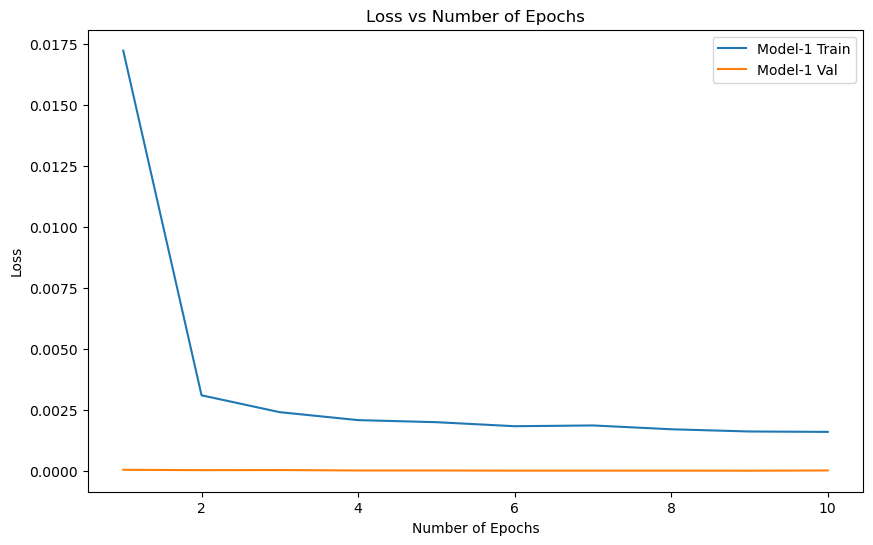

Loss: 0.0000
Test Loss: tensor(1.3203e-05)


In [22]:
## Model-1:
task_type = 'regression'
in_channels = [1, 8, 16, 32]
out_channel = 64
img_size = 128
num_epoch = 10

net_reg_1 = CNN(list_in_channels=in_channels, final_out_channel=out_channel, img_size=img_size, task=task_type, fn=fn).to(device)
optimizer = optim.Adam(net_reg_1.parameters(), lr=0.001)

train_losses, val_losses = fit(net_reg_1, num_epoch=num_epoch, optimizer=optimizer, fn=fn, task_type=task_type, train_loader=train_loader, val_loader=val_loader)

plot_losses('Model-1', num_epoch, train_losses, val_losses)
predictions, test_loss = predict(net_reg_1, test_loader, fn=fn, task_type=task_type)
print('Test Loss:', test_loss)

**MODEL-2**

Epoch: 1, Average Loss: 0.6761
Validation   Loss: 0.0293
Epoch: 2, Average Loss: 0.0185
Validation   Loss: 0.0215
Epoch: 3, Average Loss: 0.0134
Validation   Loss: 0.0081
Epoch: 4, Average Loss: 0.0099
Validation   Loss: 0.0069
Epoch: 5, Average Loss: 0.0082
Validation   Loss: 0.0068
Epoch: 6, Average Loss: 0.0073
Validation   Loss: 0.0073
Epoch: 7, Average Loss: 0.0064
Validation   Loss: 0.0075
Epoch: 8, Average Loss: 0.0058
Validation   Loss: 0.0052
Epoch: 9, Average Loss: 0.0052
Validation   Loss: 0.0051
Epoch: 10, Average Loss: 0.0047
Validation   Loss: 0.0071


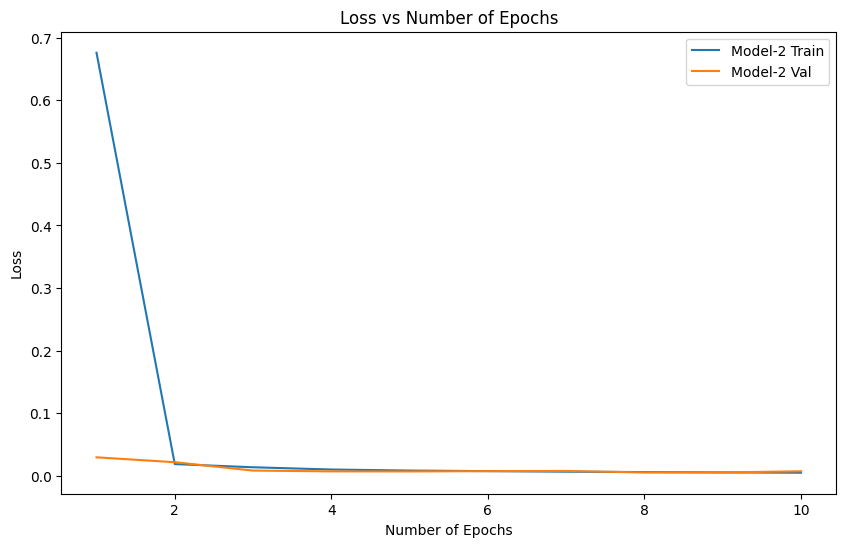

Loss: 0.0060
Test Loss: 0.0059590150000682724


In [ ]:
# Hyper-parameter tuning for Classification
## Model-1:
task_type = 'regression'
in_channels = [1,8]
out_channel = 64
img_size = 128
num_epoch = 10

net_reg_2 = CNN(list_in_channels=in_channels,final_out_channel=out_channel,img_size=img_size,task=task_type, fn=fn).to(device)
optimizer = optim.Adam(net_reg_2.parameters(), lr=0.001)

train_losses,val_losses = fit(net_reg_2,num_epoch=num_epoch,optimizer=optimizer,fn=fn,task_type=task_type,train_loader=train_loader,val_loader=val_loader)

plot_losses('Model-2',num_epoch,train_losses,val_losses)
predictions,test_loss = predict(net_reg_2,test_loader,fn=fn,task_type=task_type)
print('Test Loss:',test_loss)



**MODEL-3**

Epoch: 1, Average Loss: 0.0842
Validation   Loss: 0.0521
Epoch: 2, Average Loss: 0.0597
Validation   Loss: 0.0413
Epoch: 3, Average Loss: 0.0520
Validation   Loss: 0.0360
Epoch: 4, Average Loss: 0.0477
Validation   Loss: 0.0328
Epoch: 5, Average Loss: 0.0447
Validation   Loss: 0.0307
Epoch: 6, Average Loss: 0.0424
Validation   Loss: 0.0289
Epoch: 7, Average Loss: 0.0406
Validation   Loss: 0.0276
Epoch: 8, Average Loss: 0.0390
Validation   Loss: 0.0264
Epoch: 9, Average Loss: 0.0378
Validation   Loss: 0.0254
Epoch: 10, Average Loss: 0.0366
Validation   Loss: 0.0246


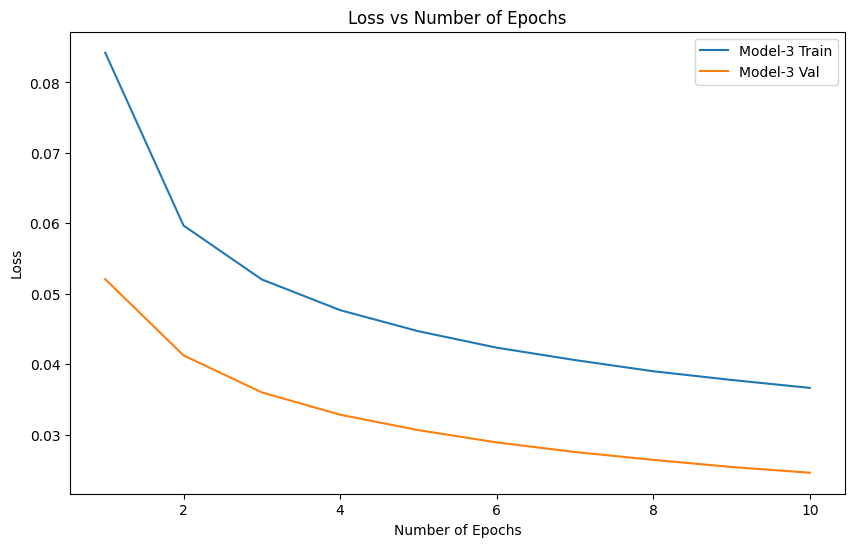

Loss: 0.0334
Test Loss: 0.033383046496763


In [ ]:
task_type = 'regression'
in_channels = [1,8,16,32]
out_channel = 64
img_size = 128
num_epoch = 10

net_reg_3 = CNN(list_in_channels=in_channels,final_out_channel=out_channel,img_size=img_size,task=task_type, fn=fn).to(device)
optimizer = optim.SGD(net_reg_3.parameters(), lr=0.001)

train_losses,val_losses = fit(net_reg_3,num_epoch=num_epoch,optimizer=optimizer,fn=fn,task_type=task_type,train_loader=train_loader,val_loader=val_loader)

plot_losses('Model-3',num_epoch,train_losses,val_losses)
predictions,test_loss = predict(net_reg_3,test_loader,fn=fn,task_type=task_type)
print('Test Loss:',test_loss)

**MODEL-4**

Epoch: 1, Average Loss: 119.4439
Validation   Loss: 0.0718
Epoch: 2, Average Loss: 0.0657
Validation   Loss: 0.0619
Epoch: 3, Average Loss: 0.0637
Validation   Loss: 0.0617
Epoch: 4, Average Loss: 0.0637
Validation   Loss: 0.0617
Epoch: 5, Average Loss: 0.0637
Validation   Loss: 0.0617
Epoch: 6, Average Loss: 0.0637
Validation   Loss: 0.0617
Epoch: 7, Average Loss: 0.0637
Validation   Loss: 0.0617
Epoch: 8, Average Loss: 0.0637
Validation   Loss: 0.0617
Epoch: 9, Average Loss: 0.0637
Validation   Loss: 0.0618
Epoch: 10, Average Loss: 0.0637
Validation   Loss: 0.0618


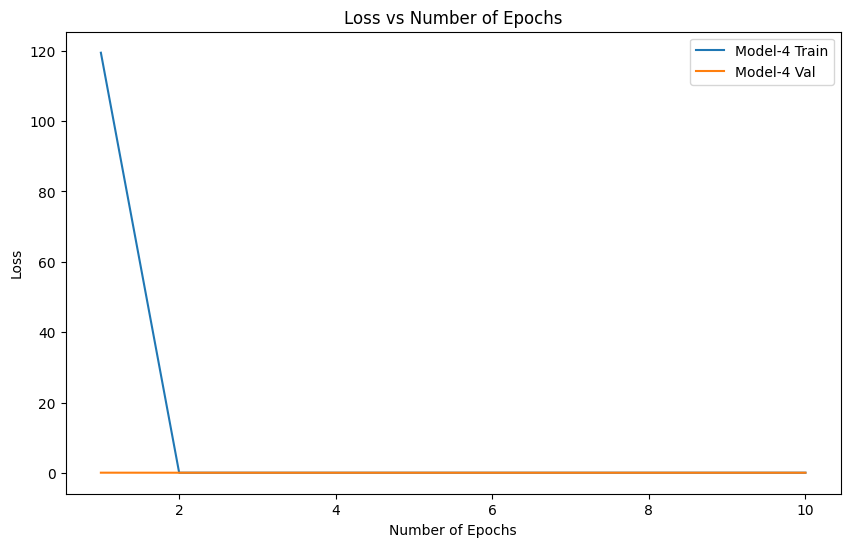

Loss: 0.0679
Test Loss: 0.06789616777354644


In [ ]:
task_type = 'regression'
in_channels = [1,8,16,32]
out_channel = 64
img_size = 128
num_epoch = 10

net_reg_4 = CNN(list_in_channels=in_channels,final_out_channel=out_channel,img_size=img_size,task=task_type, fn=fn).to(device)
optimizer = optim.Adam(net_reg_4.parameters(), lr=0.05)

train_losses,val_losses = fit(net_reg_4,num_epoch=num_epoch,optimizer=optimizer,fn=fn,task_type=task_type,train_loader=train_loader,val_loader=val_loader)

plot_losses('Model-4',num_epoch,train_losses,val_losses)
predictions,test_loss = predict(net_reg_4,test_loader,fn=fn,task_type=task_type)
print('Test Loss:',test_loss)

**MODEL-5**

Epoch: 1, Average Loss: 0.0732
Validation   Loss: 0.0355
Epoch: 2, Average Loss: 0.0503
Validation   Loss: 0.0293
Epoch: 3, Average Loss: 0.0401
Validation   Loss: 0.0252
Epoch: 4, Average Loss: 0.0339
Validation   Loss: 0.0222
Epoch: 5, Average Loss: 0.0288
Validation   Loss: 0.0197
Epoch: 6, Average Loss: 0.0251
Validation   Loss: 0.0176
Epoch: 7, Average Loss: 0.0220
Validation   Loss: 0.0162
Epoch: 8, Average Loss: 0.0196
Validation   Loss: 0.0147
Epoch: 9, Average Loss: 0.0176
Validation   Loss: 0.0135
Epoch: 10, Average Loss: 0.0160
Validation   Loss: 0.0125


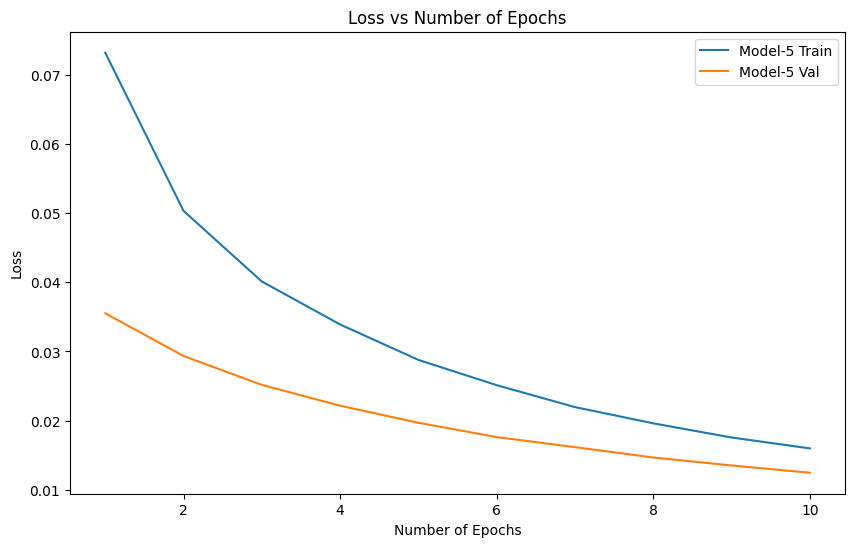

Loss: 0.0116
Test Loss: 0.011567787726461474


In [ ]:
task_type = 'regression'
in_channels = [1,8]
out_channel = 64
img_size = 128
num_epoch = 10

net_reg_5 = CNN(list_in_channels=in_channels,final_out_channel=out_channel,img_size=img_size,task=task_type, fn=fn,drop_rate=0.4).to(device)
optimizer = optim.SGD(net_reg_5.parameters(), lr=0.001)

train_losses,val_losses = fit(net_reg_5,num_epoch=num_epoch,optimizer=optimizer,fn=fn,task_type=task_type,train_loader=train_loader,val_loader=val_loader)

plot_losses('Model-5',num_epoch,train_losses,val_losses)
predictions,test_loss = predict(net_reg_5,test_loader,fn=fn,task_type=task_type)
print('Test Loss:',test_loss)

`task_type` = `classification`

**MODEL-1**

Epoch: 1, Average Loss: 1.5635, Training Accuracy: 90.03%
Validation   Loss: 1.4620, Accuracy: 99.97%
Epoch: 2, Average Loss: 1.4630, Training Accuracy: 99.83%
Validation   Loss: 1.4620, Accuracy: 99.93%
Epoch: 3, Average Loss: 1.4624, Training Accuracy: 99.92%
Validation   Loss: 1.4615, Accuracy: 99.97%
Epoch: 4, Average Loss: 1.4614, Training Accuracy: 99.99%
Validation   Loss: 1.4612, Accuracy: 100.00%
Epoch: 5, Average Loss: 1.4612, Training Accuracy: 100.00%
Validation   Loss: 1.4612, Accuracy: 100.00%
Epoch: 6, Average Loss: 1.4617, Training Accuracy: 99.94%
Validation   Loss: 1.4659, Accuracy: 99.53%
Epoch: 7, Average Loss: 1.4679, Training Accuracy: 99.33%
Validation   Loss: 1.4612, Accuracy: 100.00%
Epoch: 8, Average Loss: 1.4618, Training Accuracy: 99.94%
Validation   Loss: 1.4616, Accuracy: 99.97%
Epoch: 9, Average Loss: 1.4627, Training Accuracy: 99.86%
Validation   Loss: 1.4613, Accuracy: 99.97%
Epoch: 10, Average Loss: 1.4613, Training Accuracy: 99.98%
Validation   Loss: 

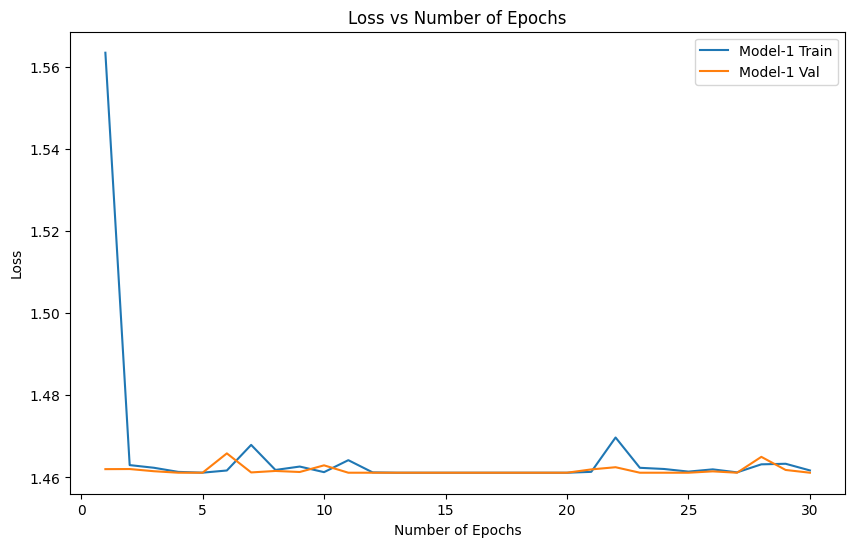

Loss: 1.4612, Accuracy: 100.00%
Test Loss: 1.4611507910821173


In [10]:
# Hyper-parameter tuning for Classification
## Model-1:
task_type = 'classification'
in_channels = [1,8,16,32]
out_channel = 64
img_size = 128
num_epoch = 30

net_cl_1 = CNN(list_in_channels=in_channels,final_out_channel=out_channel,img_size=img_size,task=task_type, fn=fn).to(device)
optimizer = optim.Adam(net_cl_1.parameters(), lr=0.001)

train_losses,val_losses = fit(net_cl_1,num_epoch=num_epoch,optimizer=optimizer,fn=fn,task_type=task_type,train_loader=train_loader,val_loader=val_loader)

plot_losses('Model-1',num_epoch,train_losses,val_losses)
predictions,test_loss = predict(net_cl_1,test_loader,fn=fn,task_type=task_type)
print('Test Loss:',test_loss)



**MODEL-2**

Epoch: 1, Average Loss: 1.6549, Training Accuracy: 80.70%
Validation   Loss: 1.5923, Accuracy: 86.90%
Epoch: 2, Average Loss: 1.6115, Training Accuracy: 84.95%
Validation   Loss: 1.5799, Accuracy: 88.13%
Epoch: 3, Average Loss: 1.6143, Training Accuracy: 84.69%
Validation   Loss: 1.5829, Accuracy: 87.87%
Epoch: 4, Average Loss: 1.6096, Training Accuracy: 85.16%
Validation   Loss: 1.5798, Accuracy: 88.17%
Epoch: 5, Average Loss: 1.6191, Training Accuracy: 84.17%
Validation   Loss: 1.5808, Accuracy: 88.07%
Epoch: 6, Average Loss: 1.5787, Training Accuracy: 88.23%
Validation   Loss: 1.5273, Accuracy: 93.40%
Epoch: 7, Average Loss: 1.5434, Training Accuracy: 91.77%
Validation   Loss: 1.5289, Accuracy: 93.23%
Epoch: 8, Average Loss: 1.5526, Training Accuracy: 90.85%
Validation   Loss: 1.5421, Accuracy: 91.87%
Epoch: 9, Average Loss: 1.5495, Training Accuracy: 91.17%
Validation   Loss: 1.5265, Accuracy: 93.47%
Epoch: 10, Average Loss: 1.5451, Training Accuracy: 91.60%
Validation   Loss: 1.53

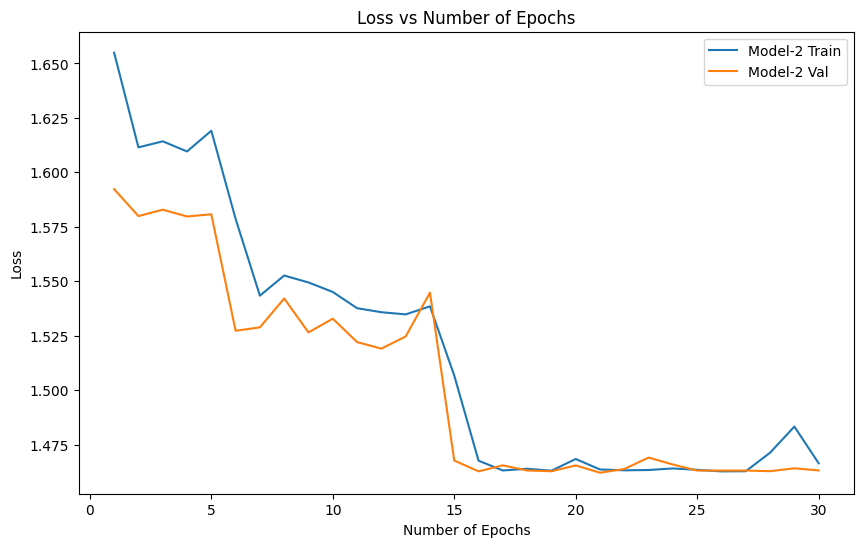

Loss: 1.4618, Accuracy: 99.93%
Test Loss: 1.461801815364096


In [ ]:
task_type = 'classification'
in_channels = [1,16,32]
out_channel = 64
img_size = 128
num_epoch = 30

net_cl_2 = CNN(list_in_channels=in_channels,final_out_channel=out_channel,img_size=img_size,task=task_type, fn=fn).to(device)
optimizer = optim.Adam(net_cl_2.parameters(), lr=0.001)

train_losses,val_losses = fit(net_cl_2,num_epoch=num_epoch,optimizer=optimizer,fn=fn,task_type=task_type,train_loader=train_loader,val_loader=val_loader)

plot_losses('Model-2',num_epoch,train_losses,val_losses)
predictions,test_loss = predict(net_cl_2,test_loader,fn=fn,task_type=task_type)
print('Test Loss:',test_loss)



**MODEL-3**

Epoch: 1, Average Loss: 2.1757, Training Accuracy: 44.27%
Validation   Loss: 1.9339, Accuracy: 72.63%
Epoch: 2, Average Loss: 1.8484, Training Accuracy: 71.99%
Validation   Loss: 1.7495, Accuracy: 77.70%
Epoch: 3, Average Loss: 1.7594, Training Accuracy: 74.82%
Validation   Loss: 1.7046, Accuracy: 79.27%
Epoch: 4, Average Loss: 1.7322, Training Accuracy: 75.55%
Validation   Loss: 1.6861, Accuracy: 79.73%
Epoch: 5, Average Loss: 1.7194, Training Accuracy: 75.83%
Validation   Loss: 1.6763, Accuracy: 79.93%
Epoch: 6, Average Loss: 1.7119, Training Accuracy: 75.97%
Validation   Loss: 1.6705, Accuracy: 79.93%
Epoch: 7, Average Loss: 1.7073, Training Accuracy: 76.06%
Validation   Loss: 1.6666, Accuracy: 79.93%
Epoch: 8, Average Loss: 1.7045, Training Accuracy: 76.03%
Validation   Loss: 1.6638, Accuracy: 79.93%
Epoch: 9, Average Loss: 1.7018, Training Accuracy: 76.10%
Validation   Loss: 1.6617, Accuracy: 79.93%
Epoch: 10, Average Loss: 1.7002, Training Accuracy: 76.12%
Validation   Loss: 1.66

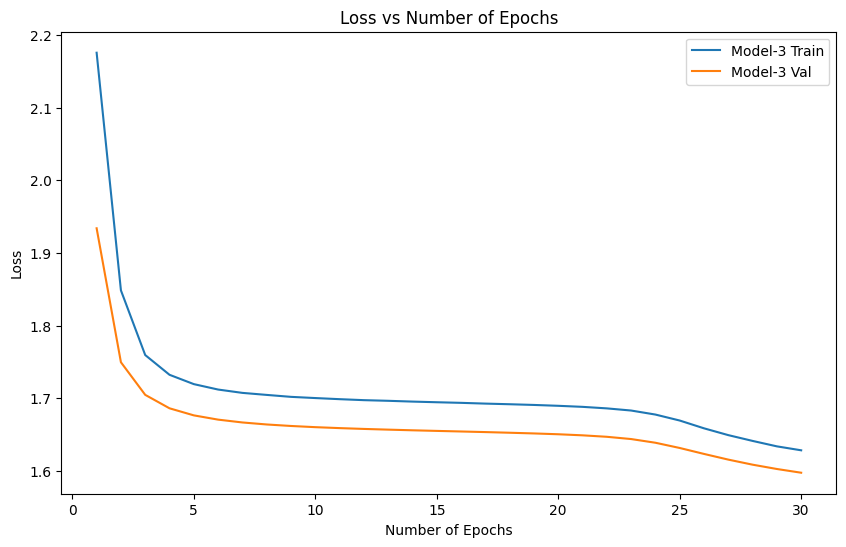

Loss: 1.6944, Accuracy: 78.65%
Test Loss: 1.6944137911001842


In [ ]:
task_type = 'classification'
in_channels = [1,8,32,64]
out_channel = 64
img_size = 128
num_epoch = 30

net_cl_3 = CNN(list_in_channels=in_channels,final_out_channel=out_channel,img_size=img_size,task=task_type, fn=fn).to(device)
optimizer = optim.SGD(net_cl_3.parameters(), lr=0.001)

train_losses,val_losses = fit(net_cl_3,num_epoch=num_epoch,optimizer=optimizer,fn=fn,task_type=task_type,train_loader=train_loader,val_loader=val_loader)

plot_losses('Model-3',num_epoch,train_losses,val_losses)
predictions,test_loss = predict(net_cl_3,test_loader,fn=fn,task_type=task_type)
print('Test Loss:',test_loss)



**MODEL-4**

Epoch: 1, Average Loss: 1.9543, Training Accuracy: 50.67%
Validation   Loss: 1.9277, Accuracy: 53.33%
Epoch: 2, Average Loss: 1.9532, Training Accuracy: 50.79%
Validation   Loss: 1.9277, Accuracy: 53.33%
Epoch: 3, Average Loss: 1.9532, Training Accuracy: 50.79%
Validation   Loss: 1.9277, Accuracy: 53.33%
Epoch: 4, Average Loss: 1.9532, Training Accuracy: 50.79%
Validation   Loss: 1.9277, Accuracy: 53.33%
Epoch: 5, Average Loss: 1.9532, Training Accuracy: 50.79%
Validation   Loss: 1.9277, Accuracy: 53.33%
Epoch: 6, Average Loss: 1.9532, Training Accuracy: 50.79%
Validation   Loss: 1.9277, Accuracy: 53.33%
Epoch: 7, Average Loss: 1.9532, Training Accuracy: 50.79%
Validation   Loss: 1.9277, Accuracy: 53.33%
Epoch: 8, Average Loss: 1.9532, Training Accuracy: 50.79%
Validation   Loss: 1.9277, Accuracy: 53.33%
Epoch: 9, Average Loss: 1.9532, Training Accuracy: 50.79%
Validation   Loss: 1.9277, Accuracy: 53.33%
Epoch: 10, Average Loss: 1.9532, Training Accuracy: 50.79%
Validation   Loss: 1.92

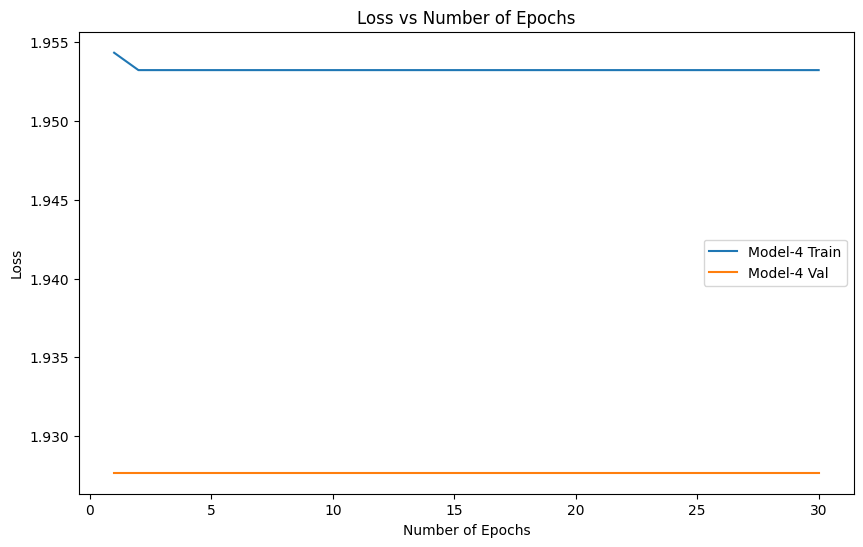

Loss: 2.0265, Accuracy: 43.48%
Test Loss: 2.0264720585611133


In [ ]:
task_type = 'classification'
in_channels = [1,8,16,32]
out_channel = 64
img_size = 128
num_epoch = 30

net_cl_4 = CNN(list_in_channels=in_channels,final_out_channel=out_channel,img_size=img_size,task=task_type, fn=fn).to(device)
optimizer = optim.Adam(net_cl_4.parameters(), lr=0.01)

train_losses,val_losses = fit(net_cl_4,num_epoch=num_epoch,optimizer=optimizer,fn=fn,task_type=task_type,train_loader=train_loader,val_loader=val_loader)

plot_losses('Model-4',num_epoch,train_losses,val_losses)
predictions,test_loss = predict(net_cl_4,test_loader,fn=fn,task_type=task_type)
print('Test Loss:',test_loss)



**MODEL-5**

Epoch: 1, Average Loss: 2.1487, Training Accuracy: 43.05%
Validation   Loss: 1.9313, Accuracy: 71.53%
Epoch: 2, Average Loss: 1.8629, Training Accuracy: 70.56%
Validation   Loss: 1.7663, Accuracy: 76.70%
Epoch: 3, Average Loss: 1.7760, Training Accuracy: 73.80%
Validation   Loss: 1.7192, Accuracy: 78.73%
Epoch: 4, Average Loss: 1.7450, Training Accuracy: 74.90%
Validation   Loss: 1.6982, Accuracy: 79.23%
Epoch: 5, Average Loss: 1.7305, Training Accuracy: 75.42%
Validation   Loss: 1.6864, Accuracy: 79.43%
Epoch: 6, Average Loss: 1.7216, Training Accuracy: 75.60%
Validation   Loss: 1.6791, Accuracy: 79.60%
Epoch: 7, Average Loss: 1.7151, Training Accuracy: 75.80%
Validation   Loss: 1.6740, Accuracy: 79.73%
Epoch: 8, Average Loss: 1.7109, Training Accuracy: 75.93%
Validation   Loss: 1.6704, Accuracy: 79.77%
Epoch: 9, Average Loss: 1.7078, Training Accuracy: 75.93%
Validation   Loss: 1.6677, Accuracy: 79.87%
Epoch: 10, Average Loss: 1.7055, Training Accuracy: 76.04%
Validation   Loss: 1.66

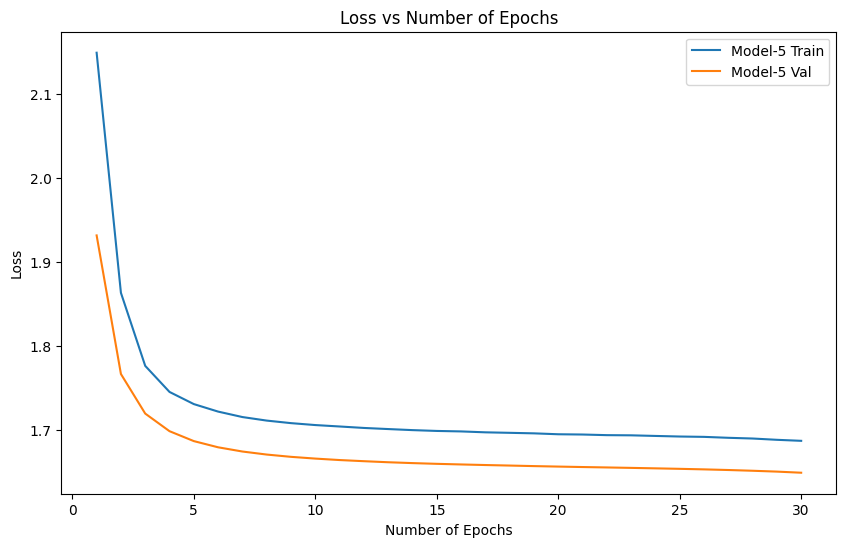

Loss: 1.7870, Accuracy: 65.24%
Test Loss: 1.7870409629411168


In [ ]:
task_type = 'classification'
in_channels = [1,8,16,32]
out_channel = 64
img_size = 128
num_epoch = 30

net_cl_5 = CNN(list_in_channels=in_channels,final_out_channel=out_channel,img_size=img_size,task=task_type, fn=fn,drop_rate=0.35).to(device)
optimizer = optim.SGD(net_cl_5.parameters(), lr=0.001)

train_losses,val_losses = fit(net_cl_5,num_epoch=num_epoch,optimizer=optimizer,fn=fn,task_type=task_type,train_loader=train_loader,val_loader=val_loader)

plot_losses('Model-5',num_epoch,train_losses,val_losses)
predictions,test_loss = predict(net_cl_5,test_loader,fn=fn,task_type=task_type)
print('Test Loss:',test_loss)



In [11]:
# Best Classification Model :
best_class_model = net_cl_1

# Best Regression Model :
best_reg_model = net_reg_1


pred_class, test_loss_class = predict(best_class_model,test_loader,fn=fn,task_type='classification')
pred_reg, test_loss_reg = predict(best_reg_model,test_loader,fn=fn,task_type='regression')


Loss: 1.4612, Accuracy: 100.00%
Loss: 0.0003


## Analysis for fn = Count
- Regression
    - The best model for regression task is net_reg_1 with the following hyper-parameters:
        1) in_channels = [1, 8, 16, 32]
        2) out_channel = 64
        3) optimizer = Adam
        4) learning_rate = 0.001
        5) dropout_rate = 0.2

    - Loss Obtained : 
        1) Train Loss : 0.0003
        2) Val Loss : 0.0003
        3) Test Loss :  0.0003432669580231757

- Classification 
    - The best model for classification task is net_cl_1 with the following hyper-parameters:
        1) in_channels = [1,8,16,32]
        2) out_channel = 64
        3) optimizer = Adam
        4) learning_rate = 0.001
        5) dropout_rate = 0.2
    
    - Metrics Obtained :
        1) Training Loss - 1.4617, Training Accuracy: 99.94%
        2) Validation Loss: 1.4612, Accuracy: 100.00%
        3) Test Loss: 1.4611507910821173 , Accuracy: 100.00%

- The loss for both of them is differnt because we are using different loss functions and the outcomes are differnt in the two cases.



The accuracy using regression model is achieved through taking the `index` of the `max_value` of the 10 elements of `pred_reg`.

In [ ]:

true_values = []
for _,batch_labels in test_loader:
  batch_labels = [string_to_digit(label) for label in batch_labels]
  label_lengths = np.sum(batch_labels, axis=1)
  true_values.extend(label_lengths)

true_values = np.array(true_values)
pred_reg = [np.argmax(arr) for arr in pred_reg]

reg_acc = np.mean(pred_reg == true_values)
print('Regression Accuracy:',reg_acc)

class_acc = np.mean(np.argmax(pred_class,axis=1) == true_values)
print('Classification Accuracy:',class_acc)











Regression Accuracy: 1.0
Classification Accuracy: 0.9997826086956522


From the above we can see that the accuracy obtained using `best_reg_model` and `best_class_model` is almost same.

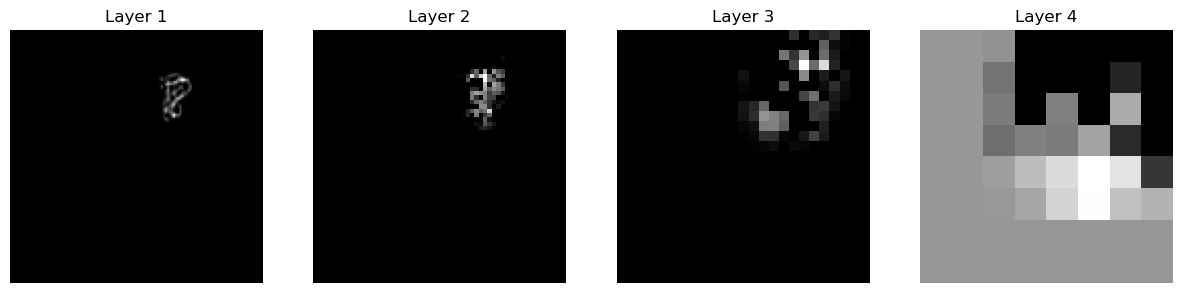

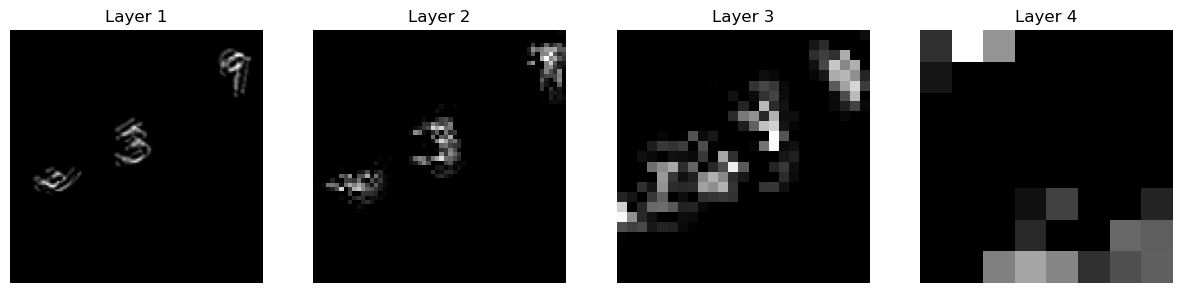

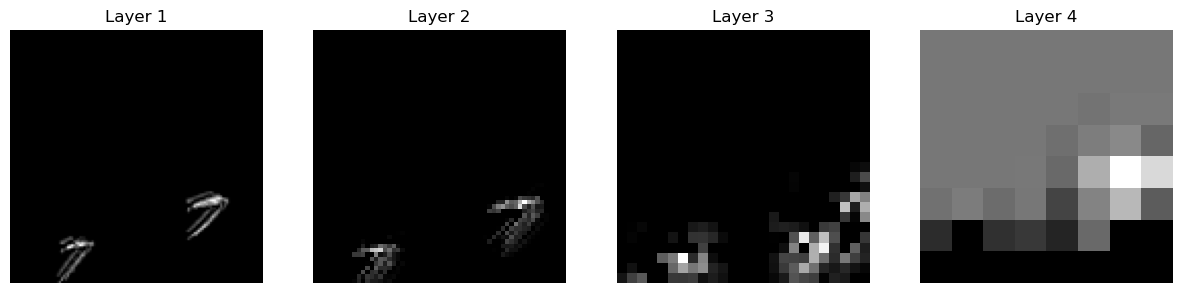

In [24]:
import torch
import matplotlib.pyplot as plt

def visualize_feature_maps(model, data_loader, num_images=3):
    model.eval()
    images_processed = 0
    with torch.no_grad():
        for image, _ in data_loader:
            if images_processed >= num_images:
                break

            image = torch.tensor(image).to(device).float()
            _, feature_maps = model(image.unsqueeze(1))

            fig, axes = plt.subplots(1, len(feature_maps), figsize=(15, 5))


            for layer_idx, fmap in enumerate(feature_maps):
                axes[layer_idx].imshow(fmap[0, 0].cpu().numpy(), cmap='gray')
                axes[layer_idx].axis('off')
                axes[layer_idx].set_title(f"Layer {layer_idx + 1}")

            plt.show()
            images_processed += 1

# Call the function
visualize_feature_maps(net_reg_1, train_loader)


## Feature Visualisation Summary:

1) Layer - 1:
The feature map shows distinct outlines of the numbers showing that this is learning low level representation of the images. For example it might be learning features such as shape or edges.<br>


2) Layer - 2:
This layer has a slightly more abstract representation of the numbers. It might be focusing on slightly more complex features than edges. Foe example it might be learning the texture.

3) Layer - 3:
This layer has a more abstract representation of the numbers. This has less recognizable shapes. This layer might be trying to combine the edges found in the previous layer into a complex pattern.

4) Layer - 4:
This layer is highly abstract, showing very minimal recognizable structure. We can barely understand anything that's present in this layer. 


**Multi-Label Classification**

In [25]:
import numpy as np

def exact_match_accuracy(y_true, y_pred):
    correct_count = 0
    total_count = len(y_true)

    for i in range(total_count):
        # Use np.array_equal for multi-label comparisons
        if np.array_equal(y_true[i], y_pred[i]):
            correct_count += 1

    return correct_count / total_count


def hamming_accuracy(y_true, y_pred):
    total_labels = len(y_true) * len(y_true[0])
    correct_labels = 0

    for i in range(len(y_true)):
        for j in range(len(y_true[0])):
            if y_true[i][j] == y_pred[i][j]:
                correct_labels += 1

    return correct_labels / total_labels

In [19]:
fn = 'Pred'

- For finding the count of each individual digit the activation function in the output layer is taken as linear.

- If we take sigmoid then we do get array of 10 elements but we get probability of each class.

- Through this we can only assert the presence of a particular digit but not the count of the digit.

- If we were to use ReLU instead then while training since the values become zero if they are non-positive, due to this the outcome obtained after few epoch would be only array of zeros.

- Hence we use Linear activation layer in the output layer.

- In order to calculate the accuracy, we need to follow the below steps:
    1) If the value is less than zero then set it to zero.
    2) Now the updated values can be rounded off to the nearest integer.
    3) Now we can calculate the accuracy by comparing the rounded off values with the actual values


Epoch: 1, Average Loss: 0.1800
Validation   Loss: 0.1701
Epoch: 2, Average Loss: 0.1503
Validation   Loss: 0.1493
Epoch: 3, Average Loss: 0.1161
Validation   Loss: 0.1164
Epoch: 4, Average Loss: 0.0843
Validation   Loss: 0.0923
Epoch: 5, Average Loss: 0.0586
Validation   Loss: 0.0697
Epoch: 6, Average Loss: 0.0444
Validation   Loss: 0.0459
Epoch: 7, Average Loss: 0.0372
Validation   Loss: 0.0536
Epoch: 8, Average Loss: 0.0320
Validation   Loss: 0.0758
Epoch: 9, Average Loss: 0.0283
Validation   Loss: 0.0450
Epoch: 10, Average Loss: 0.0255
Validation   Loss: 0.0373
Epoch: 11, Average Loss: 0.0231
Validation   Loss: 0.0308
Epoch: 12, Average Loss: 0.0218
Validation   Loss: 0.0347
Epoch: 13, Average Loss: 0.0197
Validation   Loss: 0.0282
Epoch: 14, Average Loss: 0.0179
Validation   Loss: 0.0373
Epoch: 15, Average Loss: 0.0171
Validation   Loss: 0.0425
Epoch: 16, Average Loss: 0.0161
Validation   Loss: 0.0302
Epoch: 17, Average Loss: 0.0149
Validation   Loss: 0.0390
Epoch: 18, Average Loss

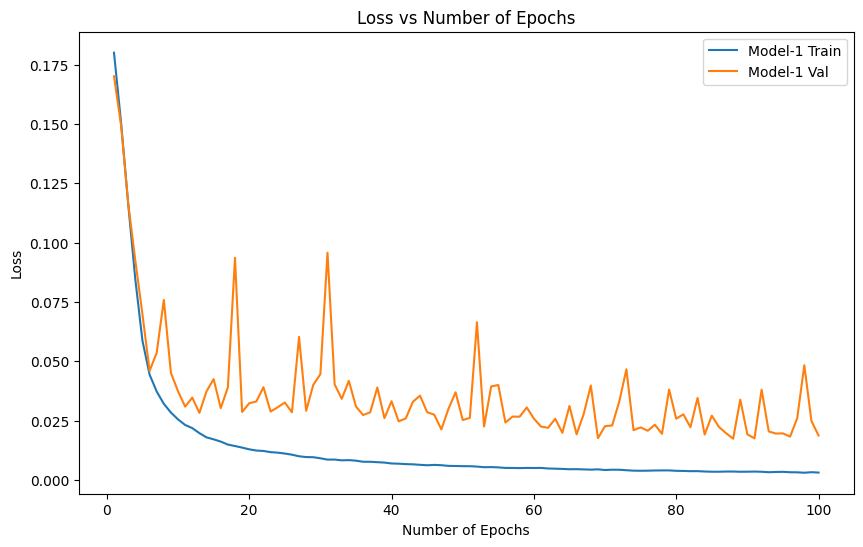

Loss: 0.0183
Test Loss: 0.01830262721503257


In [20]:
# Model - 1:
in_channels = [1,8,16,32]
out_channel = 64
img_size = 128
num_epoch = 100

net_mc_1 = CNN(list_in_channels=in_channels,final_out_channel=out_channel,img_size=img_size, fn=fn).to(device)
optimizer = optim.Adam(net_mc_1.parameters(), lr=0.001)

train_losses,val_losses = fit(net_mc_1,num_epoch=num_epoch,optimizer=optimizer,fn=fn,train_loader=train_loader,val_loader=val_loader)

plot_losses('Model-1',num_epoch,train_losses,val_losses)
predictions,test_loss = predict(net_mc_1,test_loader,fn=fn,task_type=task_type)
print('Test Loss:',test_loss)


Epoch: 1, Average Loss: 0.2648
Validation   Loss: 0.1873
Epoch: 2, Average Loss: 0.1777
Validation   Loss: 0.1850
Epoch: 3, Average Loss: 0.1713
Validation   Loss: 0.1688
Epoch: 4, Average Loss: 0.1629
Validation   Loss: 0.1679
Epoch: 5, Average Loss: 0.1613
Validation   Loss: 0.1663
Epoch: 6, Average Loss: 0.1599
Validation   Loss: 0.1636
Epoch: 7, Average Loss: 0.1577
Validation   Loss: 0.1694
Epoch: 8, Average Loss: 0.1544
Validation   Loss: 0.1641
Epoch: 9, Average Loss: 0.1521
Validation   Loss: 0.1796
Epoch: 10, Average Loss: 0.1509
Validation   Loss: 0.1643
Epoch: 11, Average Loss: 0.1504
Validation   Loss: 0.1574
Epoch: 12, Average Loss: 0.1497
Validation   Loss: 0.1559
Epoch: 13, Average Loss: 0.1492
Validation   Loss: 0.1658
Epoch: 14, Average Loss: 0.1486
Validation   Loss: 0.1625
Epoch: 15, Average Loss: 0.1481
Validation   Loss: 0.1571
Epoch: 16, Average Loss: 0.1478
Validation   Loss: 0.1560
Epoch: 17, Average Loss: 0.1478
Validation   Loss: 0.1571
Epoch: 18, Average Loss

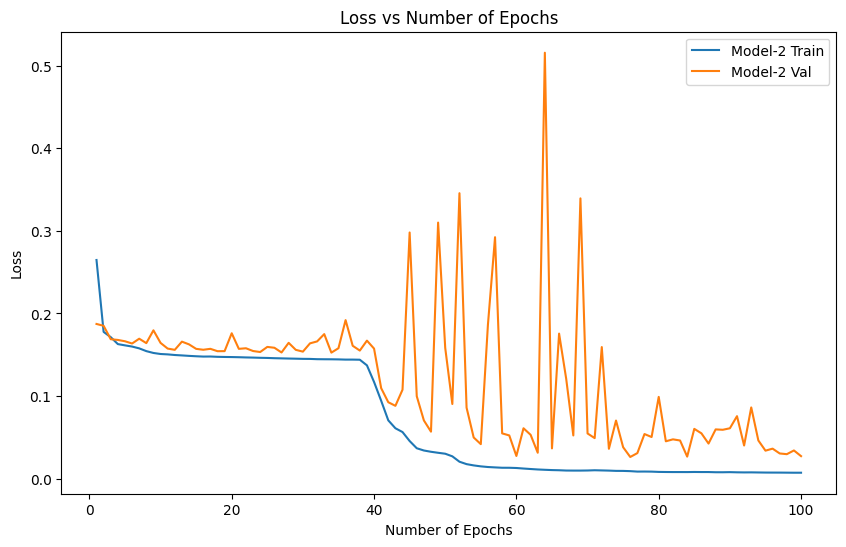

Loss: 0.0271
Test Loss: 0.02713828229914523


In [ ]:
in_channels = [1,16,32]
out_channel = 64
img_size = 128
num_epoch = 100

net_mc_2 = CNN(list_in_channels=in_channels,final_out_channel=out_channel,img_size=img_size,task=task_type, fn=fn).to(device)
optimizer = optim.Adam(net_mc_2.parameters(), lr=0.001)

train_losses,val_losses = fit(net_mc_2,num_epoch=num_epoch,optimizer=optimizer,fn=fn,task_type=task_type,train_loader=train_loader,val_loader=val_loader)

plot_losses('Model-2',num_epoch,train_losses,val_losses)
predictions,test_loss = predict(net_mc_2,test_loader,fn=fn,task_type=task_type)
print('Test Loss:',test_loss)

In [ ]:
in_channels = [1,8,16,32]
out_channel = 64
img_size = 128
num_epoch = 100

net_mc_3 = CNN(list_in_channels=in_channels,final_out_channel=out_channel,img_size=img_size,task=task_type, fn=fn).to(device)
optimizer = optim.SGD(net_mc_3.parameters(), lr=0.01)

train_losses,val_losses = fit(net_mc_3,num_epoch=num_epoch,optimizer=optimizer,fn=fn,task_type=task_type,train_loader=train_loader,val_loader=val_loader)

plot_losses('Model-3',num_epoch,train_losses,val_losses)
predictions,test_loss = predict(net_mc_3,test_loader,fn=fn,task_type=task_type)
print('Test Loss:',test_loss)

Epoch: 1, Average Loss: 0.1929
Validation   Loss: 0.1892
Epoch: 2, Average Loss: 0.1827
Validation   Loss: 0.1856
Epoch: 3, Average Loss: 0.1783
Validation   Loss: 0.1826
Epoch: 4, Average Loss: 0.1743
Validation   Loss: 0.1775
Epoch: 5, Average Loss: 0.1699
Validation   Loss: 0.1728
Epoch: 6, Average Loss: 0.1663
Validation   Loss: 0.1696
Epoch: 7, Average Loss: 0.1630
Validation   Loss: 0.1672
Epoch: 8, Average Loss: 0.1595
Validation   Loss: 0.1643
Epoch: 9, Average Loss: 0.1558
Validation   Loss: 0.1602
Epoch: 10, Average Loss: 0.1517
Validation   Loss: 0.1566
Epoch: 11, Average Loss: 0.1469
Validation   Loss: 0.1522
Epoch: 12, Average Loss: 0.1427
Validation   Loss: 0.1491
Epoch: 13, Average Loss: 0.1388
Validation   Loss: 0.1448
Epoch: 14, Average Loss: 0.1343
Validation   Loss: 0.1414
Epoch: 15, Average Loss: 0.1296
Validation   Loss: 0.1372
Epoch: 16, Average Loss: 0.1248
Validation   Loss: 0.1340
Epoch: 17, Average Loss: 0.1210
Validation   Loss: 0.1308
Epoch: 18, Average Loss

Epoch: 1, Average Loss: 0.2629
Validation   Loss: 0.1814
Epoch: 2, Average Loss: 0.1663
Validation   Loss: 0.1675
Epoch: 3, Average Loss: 0.1571
Validation   Loss: 0.1520
Epoch: 4, Average Loss: 0.1418
Validation   Loss: 0.1474
Epoch: 5, Average Loss: 0.1337
Validation   Loss: 0.1451
Epoch: 6, Average Loss: 0.1296
Validation   Loss: 0.1591
Epoch: 7, Average Loss: 0.1266
Validation   Loss: 0.1613
Epoch: 8, Average Loss: 0.1237
Validation   Loss: 0.1544
Epoch: 9, Average Loss: 0.1200
Validation   Loss: 0.1340
Epoch: 10, Average Loss: 0.1176
Validation   Loss: 0.1388
Epoch: 11, Average Loss: 0.1155
Validation   Loss: 0.1298
Epoch: 12, Average Loss: 0.1141
Validation   Loss: 0.3333
Epoch: 13, Average Loss: 0.1130
Validation   Loss: 0.1355
Epoch: 14, Average Loss: 0.1123
Validation   Loss: 0.1426
Epoch: 15, Average Loss: 0.1110
Validation   Loss: 0.1322
Epoch: 16, Average Loss: 0.1107
Validation   Loss: 0.2476
Epoch: 17, Average Loss: 0.1102
Validation   Loss: 0.1356
Epoch: 18, Average Loss

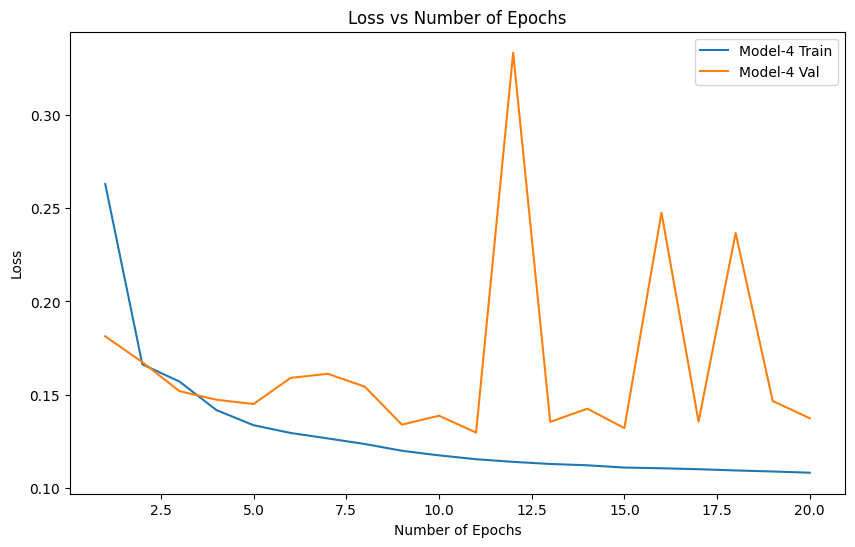

Loss: 0.1485
Test Loss: 0.1484897198776404


In [ ]:
in_channels = [1,16,32]
out_channel = 64
img_size = 128
num_epoch = 20

net_mc_4 = CNN(list_in_channels=in_channels,final_out_channel=out_channel,img_size=img_size,task=task_type, fn=fn).to(device)
optimizer = optim.Adam(net_mc_4.parameters(), lr=0.001)

train_losses,val_losses = fit(net_mc_4,num_epoch=num_epoch,optimizer=optimizer,fn=fn,task_type=task_type,train_loader=train_loader,val_loader=val_loader)

plot_losses('Model-4',num_epoch,train_losses,val_losses)
predictions,test_loss = predict(net_mc_4,test_loader,fn=fn,task_type=task_type)
print('Test Loss:',test_loss)

Epoch: 1, Average Loss: 0.1817
Validation   Loss: 0.1797
Epoch: 2, Average Loss: 0.1566
Validation   Loss: 0.1575
Epoch: 3, Average Loss: 0.1286
Validation   Loss: 0.1448
Epoch: 4, Average Loss: 0.0975
Validation   Loss: 0.0988
Epoch: 5, Average Loss: 0.0718
Validation   Loss: 0.0682
Epoch: 6, Average Loss: 0.0545
Validation   Loss: 0.0657
Epoch: 7, Average Loss: 0.0449
Validation   Loss: 0.0704
Epoch: 8, Average Loss: 0.0395
Validation   Loss: 0.0675
Epoch: 9, Average Loss: 0.0350
Validation   Loss: 0.0520
Epoch: 10, Average Loss: 0.0322
Validation   Loss: 0.0736
Epoch: 11, Average Loss: 0.0291
Validation   Loss: 0.0638
Epoch: 12, Average Loss: 0.0270
Validation   Loss: 0.0643
Epoch: 13, Average Loss: 0.0250
Validation   Loss: 0.0510
Epoch: 14, Average Loss: 0.0234
Validation   Loss: 0.0301
Epoch: 15, Average Loss: 0.0215
Validation   Loss: 0.0417
Epoch: 16, Average Loss: 0.0204
Validation   Loss: 0.0342
Epoch: 17, Average Loss: 0.0196
Validation   Loss: 0.0651
Epoch: 18, Average Loss

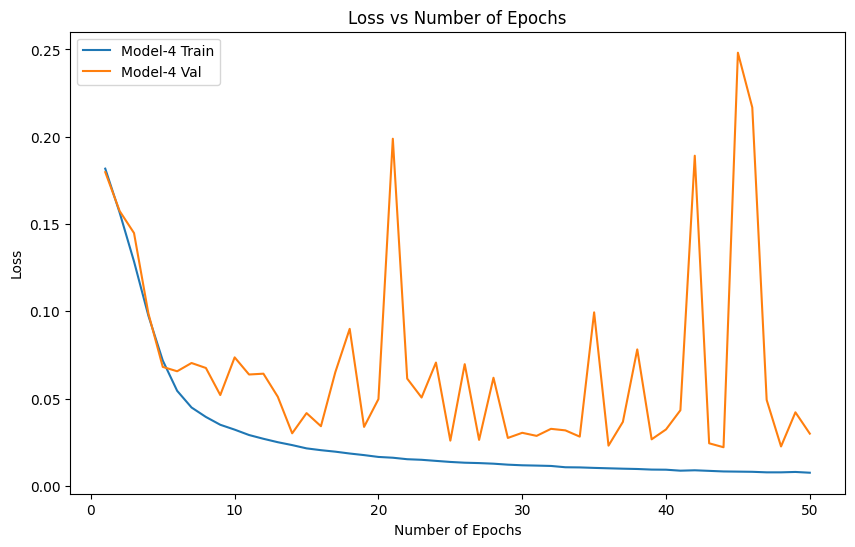

Loss: 0.0321
Test Loss: 0.032124155808964536


In [ ]:
in_channels = [1,8,16,32]
out_channel = 64
img_size = 128
num_epoch = 50

net_mc_5 = CNN(list_in_channels=in_channels,final_out_channel=out_channel,img_size=img_size,task=task_type, fn=fn,drop_rate=0.35).to(device)
optimizer = optim.Adam(net_mc_5.parameters(), lr=0.001)

train_losses,val_losses = fit(net_mc_5,num_epoch=num_epoch,optimizer=optimizer,fn=fn,task_type=task_type,train_loader=train_loader,val_loader=val_loader)

plot_losses('Model-5',num_epoch,train_losses,val_losses)
predictions,test_loss = predict(net_mc_5,test_loader,fn=fn,task_type=task_type)
print('Test Loss:',test_loss)

## Analysis for fn = Pred

The best model is net_mc_1. The following are the hyper-params:
1) in_channels = [1,8,16,32]
2) out_channel = 64
3) optimizer = Adam
4) learning_rate = 0.001
5) dropout_rate = 0.2

Metrics : 
1) Train Loss - 0.0031
2) Validation   Loss: 0.0187
3) Test Loss: 0.01830262721503257

Loss vs epoch --> figures/best_multilabel_model.png


In [32]:
def get_trueval(data_loader):
  true_labels = []
  for _,batch_labels in data_loader:
      batch_labels = [string_to_digit(label) for label in batch_labels]
      true_labels.extend(batch_labels)
      return np.array(true_labels)


In [ ]:
best_multilabel_model = net_mc_1
pred_best_test,_ = predict(best_multilabel_model,test_loader,fn=fn,task_type=task_type)
pred_best_train ,_ = predict(best_multilabel_model,train_loader,fn=fn,task_type=task_type)
pred_best_val,_ = predict(best_multilabel_model,val_loader,fn=fn,task_type=task_type)



pred_best_test = np.where(pred_best_test < 0, 0, pred_best_test)
pred_best_test = np.round(pred_best_test)


pred_best_train = np.where(pred_best_train < 0, 0, pred_best_train)
pred_best_train = np.round(pred_best_train)

pred_best_val = np.where(pred_best_val < 0, 0, pred_best_val)
pred_best_val = np.round(pred_best_val)

test_labels = get_trueval(test_loader)
val_labels = get_trueval(val_loader)
train_labels = get_trueval(train_loader)


print("Training Data")
print(f"Exact Accuracy : {exact_match_accuracy(train_labels,pred_best_train)}")
print(f"Hamming Accuracy : {hamming_accuracy(train_labels,pred_best_train)}\n\n")


print("Validation Data")
print(f"Exact Accuracy : {exact_match_accuracy(val_labels,pred_best_val)}")
print(f"Hamming Accuracy : {hamming_accuracy(val_labels,pred_best_val)}\n\n")


print("Testing Data")
print(f"Exact Accuracy : {exact_match_accuracy(test_labels,pred_best_test)}")
print(f"Hamming Accuracy : {hamming_accuracy(test_labels,pred_best_test)}\n\n")


Loss: 0.0183
Loss: 0.0038
Loss: 0.0187
Training Data
Exact Accuracy : 1.0
Hamming Accuracy : 1.0


Validation Data
Exact Accuracy : 0.78125
Hamming Accuracy : 0.975


Training Data
Exact Accuracy : 0.6875
Hamming Accuracy : 0.965625




**NOTE**<br>
In the above output there's a small typo. Here's the correct output:

Loss: 0.0183<br>
Loss: 0.0038<br>
Loss: 0.0187<br>
Training Data<br>
Exact Accuracy : 1.0<br>
Hamming Accuracy : 1.0<br>


Validation Data<br>
Exact Accuracy : 0.78125<br>
Hamming Accuracy : 0.975<br>


Testing Data<br>
Exact Accuracy : 0.6875<br>
Hamming Accuracy : 0.965625<br>

- Instead of `Training` in the third it should be `Test`,even the metrics calculated use `test_labels` and `pred_best_test`
